In [4]:
import pandas as pd
import numpy as np
import os
import operator

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score 
from sklearn.metrics import precision_recall_fscore_support, classification_report

import matplotlib.pyplot as plt
%matplotlib inline

import functools

import h5py

## Environmental vars

In [5]:
P_THRESHOLD=0.5

In [6]:
DATADIR=os.getenv('DATADIR')
RESULTS_DIR = os.path.join(DATADIR)
RESULTS_DIR

'/data/2018-07-10'

## Get some data about taxons/content

In [7]:
labelled_level2 = pd.read_csv(
    os.path.join(DATADIR, 'labelled_level2.csv.gz'),
    dtype=object,
    compression='gzip'
)

In [8]:
# Create World taxon in case any items not identified 
# through doc type in clean_content are still present
labelled_level2.loc[labelled_level2['level1taxon'] == 'World', 'level2taxon'] = 'world_level1'

In [9]:
# creating categorical variable for level2taxons from values
labelled_level2['level2taxon'] = labelled_level2['level2taxon'].astype('category')

# Add 1 because of zero-indexing to get 1-number of level2taxons as numerical targets
labelled_level2['level2taxon_code'] = labelled_level2.level2taxon.astype('category').cat.codes + 1

# create dictionary of taxon category code to string label for use in model evaluation
labels_index = dict(zip((labelled_level2['level2taxon_code']),
                        labelled_level2['level2taxon']))

## Load in data

### 1. Probability and y arrays.

In [10]:
true_train = pd.read_csv(os.path.join(RESULTS_DIR, 'true_train.csv.gz'), dtype=float, compression='gzip')
prob_train = pd.read_csv(os.path.join(RESULTS_DIR, 'train_results.csv.gz'), dtype=float, compression='gzip')

In [11]:
true_dev = pd.read_csv(os.path.join(RESULTS_DIR, 'true_dev.csv.gz'), dtype=float, compression='gzip')
prob_dev = pd.read_csv(os.path.join(RESULTS_DIR, 'dev_results.csv.gz'), dtype=float, compression='gzip')

### 2. Metadata, content_id, x, y arrays.
A bit redundant.

In [12]:
train = np.load(os.path.join(RESULTS_DIR, 'train_arrays.npz'))

In [13]:
dev = np.load(os.path.join(RESULTS_DIR, 'dev_arrays.npz'))

In [14]:
train.files

['x', 'meta', 'title', 'desc', 'y', 'content_id']

In [15]:
train['content_id']

array(['8ee15ee5-9074-4924-822d-4e38c816a3b1',
       '5e11d367-7631-11e4-a3cb-005056011aef',
       'cbc9ab5e-79e2-4044-bc18-54c46d6f9ff4', ...,
       '625236c3-c8e1-4fa6-b1ce-225f784f7e48',
       'effc6fbd-4941-4032-9ee5-f70b19577ee9',
       '5f15eaa7-7631-11e4-a3cb-005056011aef'], dtype=object)

In [16]:
train['content_id'].shape

(212885,)

In [17]:
true_train.shape[0]

212885

In [37]:
true_train.shape

(212885, 214)

## Merge results array with labelled_level2 values
content_id, metadata etc

In [18]:
def create_df_from_array(npz_array,val):
    df = pd.DataFrame()
    df[val] = npz_array[val]
    return df

In [77]:
metadata = ['document_type','publishing_app', 'primary_publishing_organisation']

In [78]:
def add_meta_to_df(meta_vars,df):
    for var in meta_vars:
        print("Working on:",var)
        df[var] = df['content_id'].map(dict(zip(labelled_level2['content_id'], labelled_level2[var])))

In [79]:
df_true = create_df_from_array(train,'content_id')
df_true = pd.concat([df_true, true_train], axis=1, join='inner')

In [80]:
add_meta_to_df(metadata,df_true)

Working on: document_type
Working on: publishing_app
Working on: primary_publishing_organisation


In [81]:
df_prob = create_df_from_array(train,'content_id')
df_prob = pd.concat([df_prob, prob_train], axis=1, join='inner')

In [82]:
add_meta_to_df(metadata,df_prob)

Working on: document_type
Working on: publishing_app
Working on: primary_publishing_organisation


In [83]:
df_true.head()

,content_id,1,2,3,4,5,6,7,8,9,...,208,209,210,211,212,213,214,document_type,publishing_app,primary_publishing_organisation
0,8ee15ee5-9074-4924-822d-4e38c816a3b1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,speech,whitehall,Department for Education
1,5e11d367-7631-11e4-a3cb-005056011aef,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,news_story,whitehall,"Prime Minister's Office, 10 Downing Street"
2,cbc9ab5e-79e2-4044-bc18-54c46d6f9ff4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,guidance,whitehall,Disclosure and Barring Service
3,5fa83648-7631-11e4-a3cb-005056011aef,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,detailed_guide,whitehall,Public Health England
4,70d84091-093f-41ee-afe3-2e6008c10b71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,answer,publisher,Government Digital Service


In [84]:
df_prob.head()

,content_id,1,2,3,4,5,6,7,8,9,...,208,209,210,211,212,213,214,document_type,publishing_app,primary_publishing_organisation
0,8ee15ee5-9074-4924-822d-4e38c816a3b1,4.717856e-13,1.453855e-10,4.703180e-11,9.020392e-11,3.707099e-11,5.433861e-11,8.485693e-12,2.140223e-15,1.934168e-08,...,5.769812e-07,1.061913e-07,3.148635e-11,4.178008e-11,3.256137e-08,1.369542e-11,7.520830e-09,speech,whitehall,Department for Education
1,5e11d367-7631-11e4-a3cb-005056011aef,8.747445e-16,2.771091e-12,3.374038e-05,4.146856e-06,1.361964e-06,1.689622e-09,8.699893e-06,5.776991e-12,3.945126e-10,...,6.033874e-09,4.579164e-12,9.812153e-13,6.342563e-10,4.521812e-08,3.227461e-11,5.341593e-11,news_story,whitehall,"Prime Minister's Office, 10 Downing Street"
2,cbc9ab5e-79e2-4044-bc18-54c46d6f9ff4,4.280072e-19,7.082074e-12,1.308827e-14,1.093841e-14,6.857230e-13,3.023671e-12,3.035368e-15,5.220151e-16,4.267607e-12,...,2.309426e-13,1.734107e-09,6.729264e-11,7.817879e-08,3.821927e-09,1.463003e-11,8.368025e-12,guidance,whitehall,Disclosure and Barring Service
3,5fa83648-7631-11e4-a3cb-005056011aef,8.144509e-14,6.764739e-12,1.491700e-18,4.786838e-19,1.379008e-17,1.314355e-15,5.164559e-21,4.051847e-17,1.706669e-12,...,3.061156e-17,5.790483e-08,1.917315e-13,2.403325e-13,4.635517e-09,1.750624e-12,3.663839e-11,detailed_guide,whitehall,Public Health England
4,70d84091-093f-41ee-afe3-2e6008c10b71,8.963274e-09,5.301263e-06,9.814490e-10,2.262713e-11,1.851227e-11,1.951133e-06,7.109739e-12,2.784299e-12,9.766106e-14,...,9.120501e-13,3.667311e-09,1.565065e-04,9.985865e-01,1.253867e-04,5.934270e-04,5.793488e-08,answer,publisher,Government Digital Service


In [85]:
df_prob

,content_id,1,2,3,4,5,6,7,8,9,...,208,209,210,211,212,213,214,document_type,publishing_app,primary_publishing_organisation
0,8ee15ee5-9074-4924-822d-4e38c816a3b1,4.717856e-13,1.453855e-10,4.703180e-11,9.020392e-11,3.707099e-11,5.433861e-11,8.485693e-12,2.140223e-15,1.934168e-08,...,5.769812e-07,1.061913e-07,3.148635e-11,4.178008e-11,3.256137e-08,1.369542e-11,7.520830e-09,speech,whitehall,Department for Education
1,5e11d367-7631-11e4-a3cb-005056011aef,8.747445e-16,2.771091e-12,3.374038e-05,4.146856e-06,1.361964e-06,1.689622e-09,8.699893e-06,5.776991e-12,3.945126e-10,...,6.033874e-09,4.579164e-12,9.812153e-13,6.342563e-10,4.521812e-08,3.227461e-11,5.341593e-11,news_story,whitehall,"Prime Minister's Office, 10 Downing Street"
2,cbc9ab5e-79e2-4044-bc18-54c46d6f9ff4,4.280072e-19,7.082074e-12,1.308827e-14,1.093841e-14,6.857230e-13,3.023671e-12,3.035368e-15,5.220151e-16,4.267607e-12,...,2.309426e-13,1.734107e-09,6.729264e-11,7.817879e-08,3.821927e-09,1.463003e-11,8.368025e-12,guidance,whitehall,Disclosure and Barring Service
3,5fa83648-7631-11e4-a3cb-005056011aef,8.144509e-14,6.764739e-12,1.491700e-18,4.786838e-19,1.379008e-17,1.314355e-15,5.164559e-21,4.051847e-17,1.706669e-12,...,3.061156e-17,5.790483e-08,1.917315e-13,2.403325e-13,4.635517e-09,1.750624e-12,3.663839e-11,detailed_guide,whitehall,Public Health England
4,70d84091-093f-41ee-afe3-2e6008c10b71,8.963274e-09,5.301263e-06,9.814490e-10,2.262713e-11,1.851227e-11,1.951133e-06,7.109739e-12,2.784299e-12,9.766106e-14,...,9.120501e-13,3.667311e-09,1.565065e-04,9.985865e-01,1.253867e-04,5.934270e-04,5.793488e-08,answer,publisher,Government Digital Service
5,78956e39-afcf-4879-8394-bc2c73ac5d74,2.563521e-14,3.114361e-08,1.333228e-20,5.664454e-16,1.449181e-14,7.254938e-14,3.516781e-21,1.431640e-17,3.374390e-20,...,2.033019e-16,3.251357e-09,1.193899e-13,1.054717e-06,8.755246e-11,1.120117e-13,8.428079e-15,detailed_guide,whitehall,"Department for Environment, Food & Rural Affairs"
6,5e359438-7631-11e4-a3cb-005056011aef,1.135625e-09,1.559862e-08,1.950221e-10,2.941575e-11,1.856206e-10,3.274629e-12,7.123652e-08,6.848797e-10,5.009676e-09,...,8.542776e-08,2.522777e-14,5.451974e-08,2.161448e-08,5.293753e-10,9.320841e-10,2.139838e-09,press_release,whitehall,Cabinet Office
7,5f1127fe-7631-11e4-a3cb-005056011aef,7.030835e-07,3.125759e-11,6.319150e-07,3.364596e-08,5.684765e-10,1.369220e-07,3.273639e-04,7.284111e-07,5.828351e-07,...,2.772327e-09,5.482167e-14,4.254243e-07,1.651421e-08,6.688644e-12,7.391021e-10,1.107051e-08,document_collection,whitehall,Ministry of Defence
8,8cb364c8-ef08-411d-98c8-0cac57fe5305,2.640104e-21,2.931591e-17,1.237137e-13,8.065726e-15,8.823958e-16,4.164549e-13,4.786665e-15,6.635968e-17,2.486663e-08,...,2.588858e-13,1.399654e-09,4.672440e-11,1.010003e-10,2.091564e-21,5.302561e-15,1.622481e-13,research,whitehall,Veterans UK
9,a7ef13c8-e445-428b-a1eb-1f38193c48de,1.109540e-13,1.036955e-12,5.970266e-14,9.457449e-16,7.515068e-16,1.840253e-08,8.119591e-16,7.353373e-15,4.523753e-08,...,3.684944e-17,7.059875e-08,6.836612e-12,4.758833e-09,4.200351e-10,1.981859e-09,5.098527e-12,guide,publisher,Government Digital Service


## Evaluate model

1. Loop over results and then compute filtered (in terms of metadata) f1 micro score. 
2. F1 score shold correspond to overall taxon performance, for a specific metadata value.
3. Correlation between metadata and F1?

In [86]:
df_prob[[str(i) for i in range(1,214)]].loc[df_prob['document_type']=='news_story'].values

array([[  8.74744530e-16,   2.77109065e-12,   3.37403799e-05, ...,
          6.34256314e-10,   4.52181190e-08,   3.22746135e-11],
       [  3.67896512e-11,   8.94324057e-13,   8.48221049e-09, ...,
          1.31937472e-09,   1.04966008e-10,   1.81867350e-07],
       [  2.07986753e-10,   3.84873057e-16,   7.04758295e-18, ...,
          2.33470882e-11,   1.71603234e-14,   2.48764947e-16],
       ..., 
       [  9.64859193e-10,   4.41177823e-11,   1.39596668e-16, ...,
          1.29759190e-10,   7.18751187e-12,   2.74486250e-12],
       [  5.19743582e-10,   2.08702566e-09,   3.81693035e-01, ...,
          4.65388575e-06,   1.27353883e-09,   4.34104273e-08],
       [  1.42890599e-06,   6.11659914e-08,   3.48476092e-08, ...,
          9.72861613e-08,   3.36746069e-07,   2.01198773e-08]])

In [87]:
def filtered_f1(meta_vars, metadata, true, probs):
    f1_scores = {}
    for i,meta in enumerate(meta_vars):

        
        number_of_samples = probs[[str(i) for i in range(1,true_train.shape[1])]].loc[probs[metadata]==meta].shape[0]

        if number_of_samples >0:

            filtered_prob_array = probs[[str(i) for i in range(1,true_train.shape[1])]].loc[probs[metadata]==meta].values

            filtered_prob_array[filtered_prob_array>=P_THRESHOLD] = 1
            filtered_prob_array[filtered_prob_array<P_THRESHOLD] = 0

            filtered_true_array = true[[str(i) for i in range(1,true_train.shape[1])]].loc[true[metadata]==meta].values

            print("same number predicted as in human labels for {} = {}".format(meta,(len(filtered_prob_array)==len(filtered_true_array))))

            f1_m = precision_recall_fscore_support(filtered_true_array, filtered_prob_array, 
                                                   average='micro', sample_weight=None)[2]
            f1_scores[meta] = f1_m

        else:
            print("Metadata value",meta,"from",metadata,"not found in set.")
        
    return f1_scores

### F1 scores in terms of meta data

In [88]:
def get_meta_lists(metadata_var):
    print("Getting values for:",metadata_var)
    print(labelled_level2[metadata_var].nunique())
    freq_meta_vals = labelled_level2[metadata_var].value_counts()
    print("Frequency dict:",[(k,v) for k,v in freq_meta_vals.items()][0:5])
    meta_vals = labelled_level2[metadata_var].unique()
    print("Value array:",meta_vals[0:4])
    
    return freq_meta_vals,meta_vals

In [89]:
_,doc_types = get_meta_lists("document_type")

Getting values for: document_type
73
Frequency dict: [('news_story', 41071), ('press_release', 28498), ('guidance', 25097), ('policy_paper', 11724), ('notice', 11683)]
Value array: ['research' 'news_story' 'consultation_outcome' 'speech']


In [90]:
_,primary_publishing_orgs = get_meta_lists("primary_publishing_organisation")

Getting values for: primary_publishing_organisation
408
Frequency dict: [('Foreign & Commonwealth Office', 18203), ('Environment Agency', 15810), ('HM Courts & Tribunals Service', 13695), ('Ministry of Defence', 10848), ('Department for Transport', 10435)]
Value array: ['Regulatory Policy Committee' 'Better Regulation Delivery Office'
 'Department for Business, Innovation & Skills'
 'Department for Environment, Food & Rural Affairs']


In [56]:
f1_train_doc_type = filtered_f1(doc_types, "document_type", df_true, df_prob)

same number predicted as in human labels for research = True
same number predicted as in human labels for news_story = True
same number predicted as in human labels for consultation_outcome = True
same number predicted as in human labels for speech = True
same number predicted as in human labels for policy_paper = True
same number predicted as in human labels for document_collection = True
same number predicted as in human labels for guidance = True
same number predicted as in human labels for press_release = True
same number predicted as in human labels for licence = True
same number predicted as in human labels for independent_report = True
same number predicted as in human labels for closed_consultation = True
same number predicted as in human labels for impact_assessment = True
same number predicted as in human labels for government_response = True
same number predicted as in human labels for form = True
same number predicted as in human labels for detailed_guide = True
same number

In [96]:
f1_train_primary_publishing_org = filtered_f1(primary_publishing_orgs, "primary_publishing_organisation", df_true, df_prob)

same number predicted as in human labels for Regulatory Policy Committee = True
same number predicted as in human labels for Better Regulation Delivery Office = True
same number predicted as in human labels for Department for Business, Innovation & Skills = True
same number predicted as in human labels for Department for Environment, Food & Rural Affairs = True
same number predicted as in human labels for Department for Business, Energy & Industrial Strategy = True
same number predicted as in human labels for Department for Work and Pensions = True
same number predicted as in human labels for Department for Transport = True
same number predicted as in human labels for Government Digital Service = True
same number predicted as in human labels for Office for Product Safety and Standards = True
same number predicted as in human labels for Health and Safety Executive = True
same number predicted as in human labels for Department for Business, Enterprise and Regulatory Reform = True
same nu

same number predicted as in human labels for Department of Health (Northern Ireland) = True
same number predicted as in human labels for Department of Health, Social Services and Public Safety = True
same number predicted as in human labels for Advisory Committee on Clinical Excellence Awards = True
same number predicted as in human labels for National Information Board = True
same number predicted as in human labels for Independent Living Fund = True
same number predicted as in human labels for National Data Guardian = True
same number predicted as in human labels for Mid Staffordshire NHS Foundation Trust Public Inquiry 2010 = True
same number predicted as in human labels for Public Health Wales = True
same number predicted as in human labels for Competition and Markets Authority = True
same number predicted as in human labels for The Scottish Government = True
same number predicted as in human labels for Care Quality Commission = True
same number predicted as in human labels for Acc

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


same number predicted as in human labels for Review Body for Nursing and Other Health Professions = True
same number predicted as in human labels for Academy for Justice Commissioning = True
same number predicted as in human labels for Her Majesty’s Prison and Probation Service = True
same number predicted as in human labels for Scottish Office = True
Metadata value United Kingdom Blood Transfusion Services from primary_publishing_organisation not found in set.
same number predicted as in human labels for Cooksey Review = True
same number predicted as in human labels for Forensic Science Regulator = True
same number predicted as in human labels for Independent Police Complaints Commission = True
same number predicted as in human labels for NHS Business Services Authority = True
same number predicted as in human labels for NHS Trust Development Authority = True
same number predicted as in human labels for Mid Staffordshire NHS Foundation Trust Public Inquiry 2013 = True
same number pred

same number predicted as in human labels for Department of the Environment (Northern Ireland) = True
same number predicted as in human labels for Joint Nature Conservation Committee = True
same number predicted as in human labels for Highways Agency = True
same number predicted as in human labels for Prison Service Pay Review Body = True
same number predicted as in human labels for Crown Commercial Service = True
same number predicted as in human labels for Airports Commission = True
same number predicted as in human labels for Traffic Commissioners for Great Britain = True
same number predicted as in human labels for Senior Salaries Review Body  = True
same number predicted as in human labels for Department of Trade and Industry = True
same number predicted as in human labels for Office of Manpower Economics = True
same number predicted as in human labels for Police Remuneration Review Body = True
same number predicted as in human labels for English Heritage = True
same number predict

same number predicted as in human labels for Education Funding Agency = True
Metadata value Independent Safeguarding Authority from primary_publishing_organisation not found in set.
same number predicted as in human labels for National Policing Improvement Agency = True
Metadata value HM Prison Service from primary_publishing_organisation not found in set.
same number predicted as in human labels for Judicial Appointments and Conduct Ombudsman = True
same number predicted as in human labels for Monopolies and Mergers Commission = True
same number predicted as in human labels for Vehicle and Operator Services Agency = True
same number predicted as in human labels for UK Statistics Authority = True
same number predicted as in human labels for Government Commercial Function = True
Metadata value National Institute for Health and Care Excellence from primary_publishing_organisation not found in set.
same number predicted as in human labels for Examination team on child care procedures and 

In [97]:
sorted_f1 = sorted(f1_train_doc_type.items(), key=operator.itemgetter(1))
sorted_f1

[('Royal Mint Advisory Committee', 0.0),
 ('Redfern Inquiry', 0.0),
 ('Review Body for Nursing and Other Health Professions', 0.0),
 ('Audit Commission', 0.0),
 ('Royal Liverpool Childrens Inquiry', 0.0),
 ('Kerr / Haslam Inquiry', 0.0),
 ('Gambling Commission', 0.0),
 ('Crown Prosecution Service', 0.0),
 ('Animal Procedures Committee', 0.0),
 ('Veterinary Products Committee', 0.0),
 ('Trinity House', 0.0),
 ('Gowers Review of Intellectual Property', 0.0),
 ('Leitch Review of Skills', 0.0),
 ("Reserve Forces' and Cadets' Associations", 0.0),
 ('Police Advisory Board for England and Wales', 0.0),
 ('HM Courts Service', 0.0),
 ('Varney Review', 0.0),
 ('Leveson Inquiry', 0.0),
 ('Department of National Heritage', 0.0),
 ('Nuclear Liabilities Financing Assurance Board', 0.0),
 ('Royal Commission on Environmental Pollution', 0.0),
 ('Office of HM Paymaster General', 0.0),
 ('Commonwealth Scholarship Commission in the UK', 0.0),
 ('Industrial Development Advisory Board', 0.0),
 ('Rosemary N

In [98]:
sorted_f1_ppo = sorted(f1_train_primary_publishing_org.items(), key=operator.itemgetter(1))
sorted_f1_ppo

[('Royal Mint Advisory Committee', 0.0),
 ('Redfern Inquiry', 0.0),
 ('Review Body for Nursing and Other Health Professions', 0.0),
 ('Audit Commission', 0.0),
 ('Royal Liverpool Childrens Inquiry', 0.0),
 ('Kerr / Haslam Inquiry', 0.0),
 ('Gambling Commission', 0.0),
 ('Crown Prosecution Service', 0.0),
 ('Animal Procedures Committee', 0.0),
 ('Veterinary Products Committee', 0.0),
 ('Trinity House', 0.0),
 ('Gowers Review of Intellectual Property', 0.0),
 ('Leitch Review of Skills', 0.0),
 ("Reserve Forces' and Cadets' Associations", 0.0),
 ('Police Advisory Board for England and Wales', 0.0),
 ('HM Courts Service', 0.0),
 ('Varney Review', 0.0),
 ('Leveson Inquiry', 0.0),
 ('Department of National Heritage', 0.0),
 ('Nuclear Liabilities Financing Assurance Board', 0.0),
 ('Royal Commission on Environmental Pollution', 0.0),
 ('Office of HM Paymaster General', 0.0),
 ('Commonwealth Scholarship Commission in the UK', 0.0),
 ('Industrial Development Advisory Board', 0.0),
 ('Rosemary N

In [99]:
len(sorted_f1_ppo)

392

### Training metrics

TBC

### Dev set metrics

Preliminary setup, workaround to getting explicit counts for resampled training data.

In [100]:
training_supp = create_df_from_array(train,'content_id')
add_meta_to_df(metadata,training_supp)

Working on: document_type
Working on: publishing_app
Working on: primary_publishing_organisation


In [102]:
support_doc = training_supp['document_type'].value_counts()
support_pub = training_supp['publishing_app'].value_counts()
support_ppo = training_supp['primary_publishing_organisation'].value_counts()

#### Set up dataframes for taxon probs/labels + content_id + metadata

In [59]:
df_true_dev = create_df_from_array(dev,'content_id')
df_true_dev = pd.concat([df_true_dev, true_dev], axis=1, join='inner')

In [104]:
add_meta_to_df(metadata,df_true_dev)

Working on: document_type
Working on: publishing_app
Working on: primary_publishing_organisation


In [105]:
df_true_dev.head()

,content_id,1,2,3,4,5,6,7,8,9,...,208,209,210,211,212,213,214,document_type,publishing_app,primary_publishing_organisation
0,2f6557bf-359e-46cb-afbb-11281534b441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,transparency,whitehall,Department for Transport
1,5f11d190-7631-11e4-a3cb-005056011aef,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,speech,whitehall,Department for Transport
2,5e2f4067-7631-11e4-a3cb-005056011aef,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,world_news_story,whitehall,NaN
3,5593b797-cf35-40ef-bbf6-6c0190806075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,employment_tribunal_decision,specialist-publisher,HM Courts & Tribunals Service
4,33268dcf-ec4f-4215-9ae5-b53b8615d1b4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,answer,publisher,Government Digital Service


In [106]:
df_prob_dev = create_df_from_array(dev,'content_id')
df_prob_dev = pd.concat([df_prob_dev, prob_dev], axis=1, join='inner')

In [107]:
add_meta_to_df(metadata,df_prob_dev)

Working on: document_type
Working on: publishing_app
Working on: primary_publishing_organisation


#### Lists containing metadata variable values

In [108]:
freq_doc, doc_list = get_meta_lists("document_type")
freq_pub_app, pub_app_list = get_meta_lists("publishing_app")

print(doc_list[0:2],pub_app_list[0:2])

Getting values for: document_type
73
Frequency dict: [('news_story', 41071), ('press_release', 28498), ('guidance', 25097), ('policy_paper', 11724), ('notice', 11683)]
Value array: ['research' 'news_story' 'consultation_outcome' 'speech']
Getting values for: publishing_app
9
Frequency dict: [('whitehall', 222318), ('specialist-publisher', 26221), ('publisher', 3423), ('hmrc-manuals-api', 83), ('policy-publisher', 82)]
Value array: ['whitehall' 'publisher' 'hmrc-manuals-api' 'policy-publisher']
['research' 'news_story'] ['whitehall' 'publisher']


#### F1 scores in terms of document_type and publishing_app.

In [109]:
f1_dev_doc = filtered_f1(doc_list, "document_type", df_true_dev, df_prob_dev)
f1_dev_pub = filtered_f1(pub_app_list, "publishing_app", df_true_dev, df_prob_dev)

f1_dev_ppo = filtered_f1(primary_publishing_orgs, "primary_publishing_organisation", df_true_dev, df_prob_dev)

same number predicted as in human labels for research = True
same number predicted as in human labels for news_story = True
same number predicted as in human labels for consultation_outcome = True
same number predicted as in human labels for speech = True
same number predicted as in human labels for policy_paper = True
same number predicted as in human labels for document_collection = True
same number predicted as in human labels for guidance = True
same number predicted as in human labels for press_release = True
same number predicted as in human labels for licence = True
same number predicted as in human labels for independent_report = True
same number predicted as in human labels for closed_consultation = True
same number predicted as in human labels for impact_assessment = True
same number predicted as in human labels for government_response = True
same number predicted as in human labels for form = True
same number predicted as in human labels for detailed_guide = True
same number

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


same number predicted as in human labels for Marine Accident Investigation Branch = True
same number predicted as in human labels for Government Chemist = True
same number predicted as in human labels for Foreign & Commonwealth Office = True
same number predicted as in human labels for Independent Reviewer of Terrorism Legislation = True
same number predicted as in human labels for Ofqual = True
same number predicted as in human labels for Regulatory Delivery = True
same number predicted as in human labels for National Measurement Office = True
same number predicted as in human labels for Environment Agency = True
same number predicted as in human labels for Cabinet Office = True
Metadata value nan from primary_publishing_organisation not found in set.
same number predicted as in human labels for Department for Digital, Culture, Media & Sport = True
same number predicted as in human labels for Ministry of Justice = True
same number predicted as in human labels for Ministry of Housing, 

same number predicted as in human labels for Valuation Office Agency = True
same number predicted as in human labels for The Parliamentary and Health Service Ombudsman  = True
same number predicted as in human labels for Review Body on Doctors' and Dentists' Remuneration = True
Metadata value Redfern Inquiry from primary_publishing_organisation not found in set.
Metadata value Review Body for Nursing and Other Health Professions from primary_publishing_organisation not found in set.
same number predicted as in human labels for Academy for Justice Commissioning = True
Metadata value Her Majesty’s Prison and Probation Service from primary_publishing_organisation not found in set.
same number predicted as in human labels for Scottish Office = True
same number predicted as in human labels for United Kingdom Blood Transfusion Services = True
Metadata value Cooksey Review from primary_publishing_organisation not found in set.
same number predicted as in human labels for Forensic Science Regu

same number predicted as in human labels for National Counter Terrorism Security Office = True
Metadata value Animal Procedures Committee from primary_publishing_organisation not found in set.
same number predicted as in human labels for Veterinary Products Committee = True
Metadata value Eliasch Review from primary_publishing_organisation not found in set.
same number predicted as in human labels for Department of the Environment (Northern Ireland) = True
Metadata value Joint Nature Conservation Committee from primary_publishing_organisation not found in set.
same number predicted as in human labels for Highways Agency = True
same number predicted as in human labels for Prison Service Pay Review Body = True
same number predicted as in human labels for Crown Commercial Service = True
same number predicted as in human labels for Airports Commission = True
same number predicted as in human labels for Traffic Commissioners for Great Britain = True
same number predicted as in human labels 

Metadata value Government Economic Service from primary_publishing_organisation not found in set.
same number predicted as in human labels for Pubs Code Adjudicator = True
Metadata value Criminal Procedure Rule Committee from primary_publishing_organisation not found in set.
Metadata value Government Veterinary Services  from primary_publishing_organisation not found in set.
Metadata value Civil Service Reform from primary_publishing_organisation not found in set.
Metadata value Government Property Profession from primary_publishing_organisation not found in set.
same number predicted as in human labels for Committee on Radioactive Waste Management = True
Metadata value Office of the Registrar of Consultant Lobbyists from primary_publishing_organisation not found in set.
Metadata value The Executive Office (Northern Ireland) from primary_publishing_organisation not found in set.
Metadata value Technical Advisory Board from primary_publishing_organisation not found in set.
Metadata valu

same number predicted as in human labels for Standards and Testing Agency = True
Metadata value Qualifications and Curriculum Authority from primary_publishing_organisation not found in set.
same number predicted as in human labels for Office of the Schools Adjudicator = True
same number predicted as in human labels for Government Legal Profession = True
Metadata value Family Procedure Rule Committee from primary_publishing_organisation not found in set.
Metadata value Export Control Joint Unit from primary_publishing_organisation not found in set.
Metadata value Board of Banking Supervision from primary_publishing_organisation not found in set.
Metadata value Financial Services Trade and Investment Board from primary_publishing_organisation not found in set.
Metadata value Inquiry into the supervision of the Bank of Credit and Commerce International from primary_publishing_organisation not found in set.
Metadata value National Forest Company from primary_publishing_organisation not fo

In [66]:
sorted(f1_dev_doc.items(), key=operator.itemgetter(1), reverse=True)

[('statistics', 1.0),
 ('aaib_report', 1.0),
 ('fatality_notice', 1.0),
 ('welsh_language_scheme', 1.0),
 ('tax_tribunal_decision', 1.0),
 ('employment_tribunal_decision', 1.0),
 ('employment_appeal_tribunal_decision', 1.0),
 ('utaac_decision', 1.0),
 ('simple_smart_answer', 1.0),
 ('international_development_fund', 1.0),
 ('cma_case', 1.0),
 ('maib_report', 1.0),
 ('raib_report', 1.0),
 ('medical_safety_alert', 1.0),
 ('drug_safety_update', 1.0),
 ('countryside_stewardship_grant', 1.0),
 ('place', 1.0),
 ('asylum_support_decision', 1.0),
 ('esi_fund', 1.0),
 ('map', 0.970873786407767),
 ('business_finance_support_scheme', 0.96551724137931039),
 ('notice', 0.94479561736198903),
 ('decision', 0.90929451287793939),
 ('official', 0.90909090909090906),
 ('transparency', 0.90159901599016001),
 ('answer', 0.89000000000000001),
 ('manual', 0.88888888888888895),
 ('transaction', 0.87878787878787867),
 ('official_statistics', 0.87544996400287978),
 ('statistics_announcement', 0.8571428571428572

In [110]:
sorted(f1_dev_ppo.items(), key=operator.itemgetter(1), reverse=True)

[('Independent Reviewer of Terrorism Legislation', 1.0),
 ('Office of the Immigration Services Commissioner', 1.0),
 ('Groceries Code Adjudicator', 1.0),
 ('Lammy Review', 1.0),
 ('Civil Nuclear Constabulary', 1.0),
 ('Civil Service Fast Track Apprenticeship', 1.0),
 ('NHS England', 1.0),
 ('Independent Reconfiguration Panel', 1.0),
 ('Morecambe Bay Investigation', 1.0),
 ('Advisory Committee on Clinical Excellence Awards', 1.0),
 ('Information Services Division (Scotland)', 1.0),
 ('Office for Disability Issues', 1.0),
 ('Criminal Injuries Compensation Authority', 1.0),
 ('Queen Elizabeth II Conference Centre', 1.0),
 ('Veterans UK', 1.0),
 ('Forestry Commission', 1.0),
 ('Agri-Food and Biosciences Institute (Northern Ireland)', 1.0),
 ('British Cattle Movement Service', 1.0),
 ('Animals in Science Committee', 1.0),
 ('Sentencing Council for England and Wales', 1.0),
 ('Airports Commission', 1.0),
 ('English Heritage', 1.0),
 ('Office of Rail Regulation', 1.0),
 ('Defence and Security

### ANALYSIS/GRAPHING FOR DOCUMENT_TYPE

In [67]:
results_doc = pd.DataFrame.from_dict(data=f1_dev_doc,orient='index').rename(columns={0:'F1_micro'}).reset_index().\
                     rename(columns={'index':'document_type',0:'F1_micro'})

In [68]:
results_doc['support_doc_type'] = results_doc['document_type'].map(lambda x: support_doc[x] if x in support_doc else 0)

In [69]:
results_doc.head()

,document_type,F1_micro,support_doc_type
0,research,0.797677,9087
1,news_story,0.783852,27196
2,consultation_outcome,0.774970,3064
3,speech,0.677378,5863
4,policy_paper,0.756347,8815


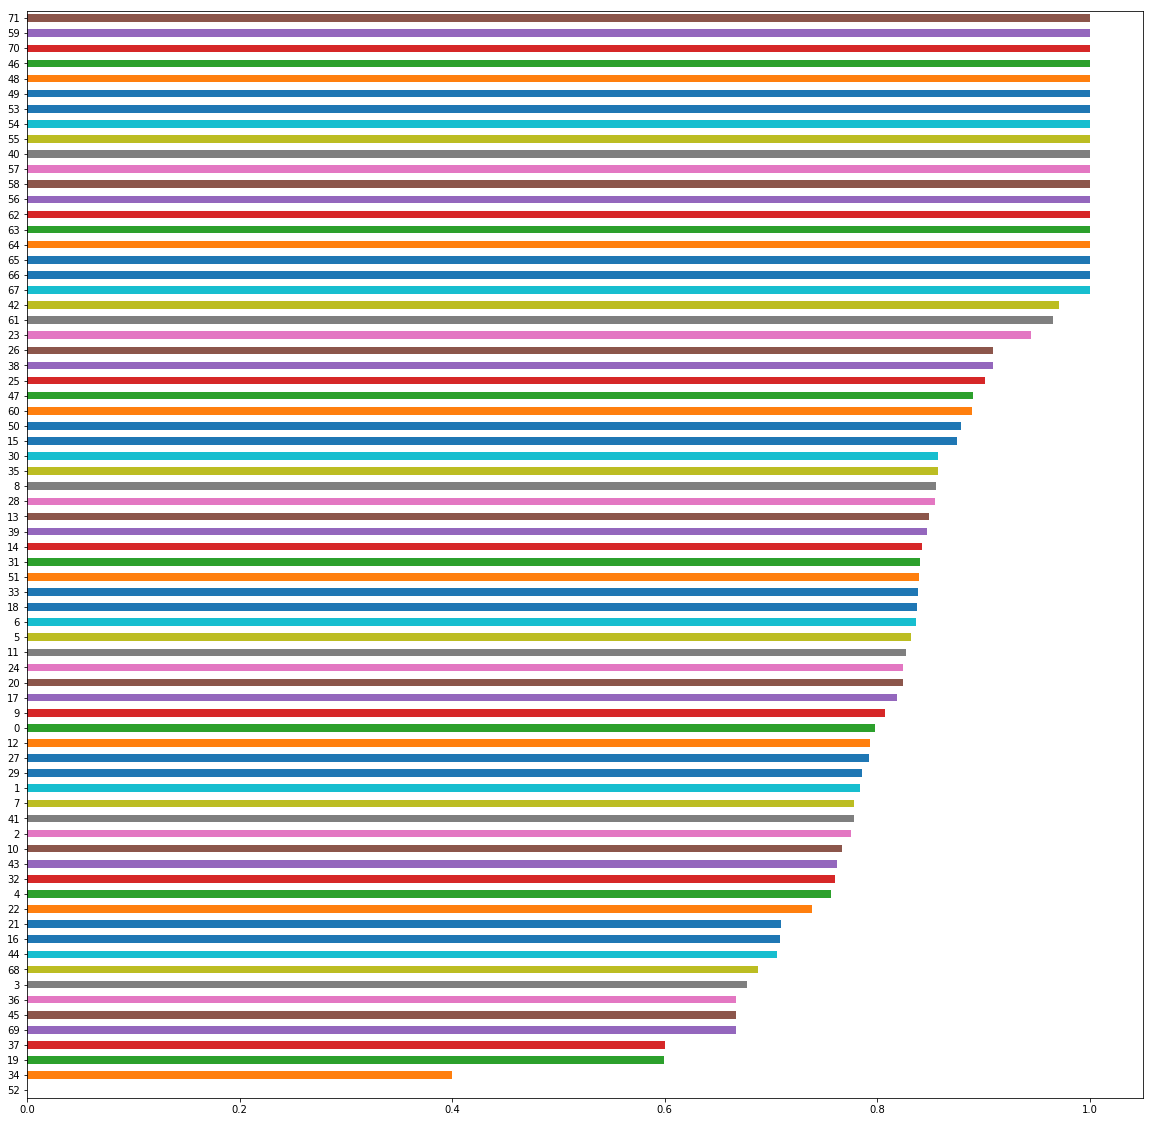

In [70]:
results_doc['F1_micro'].sort_values().plot( kind = 'barh', figsize=(20, 20))

In [71]:
results_doc['support_doc_type'].max()

27196

### Graph f1/support per document type

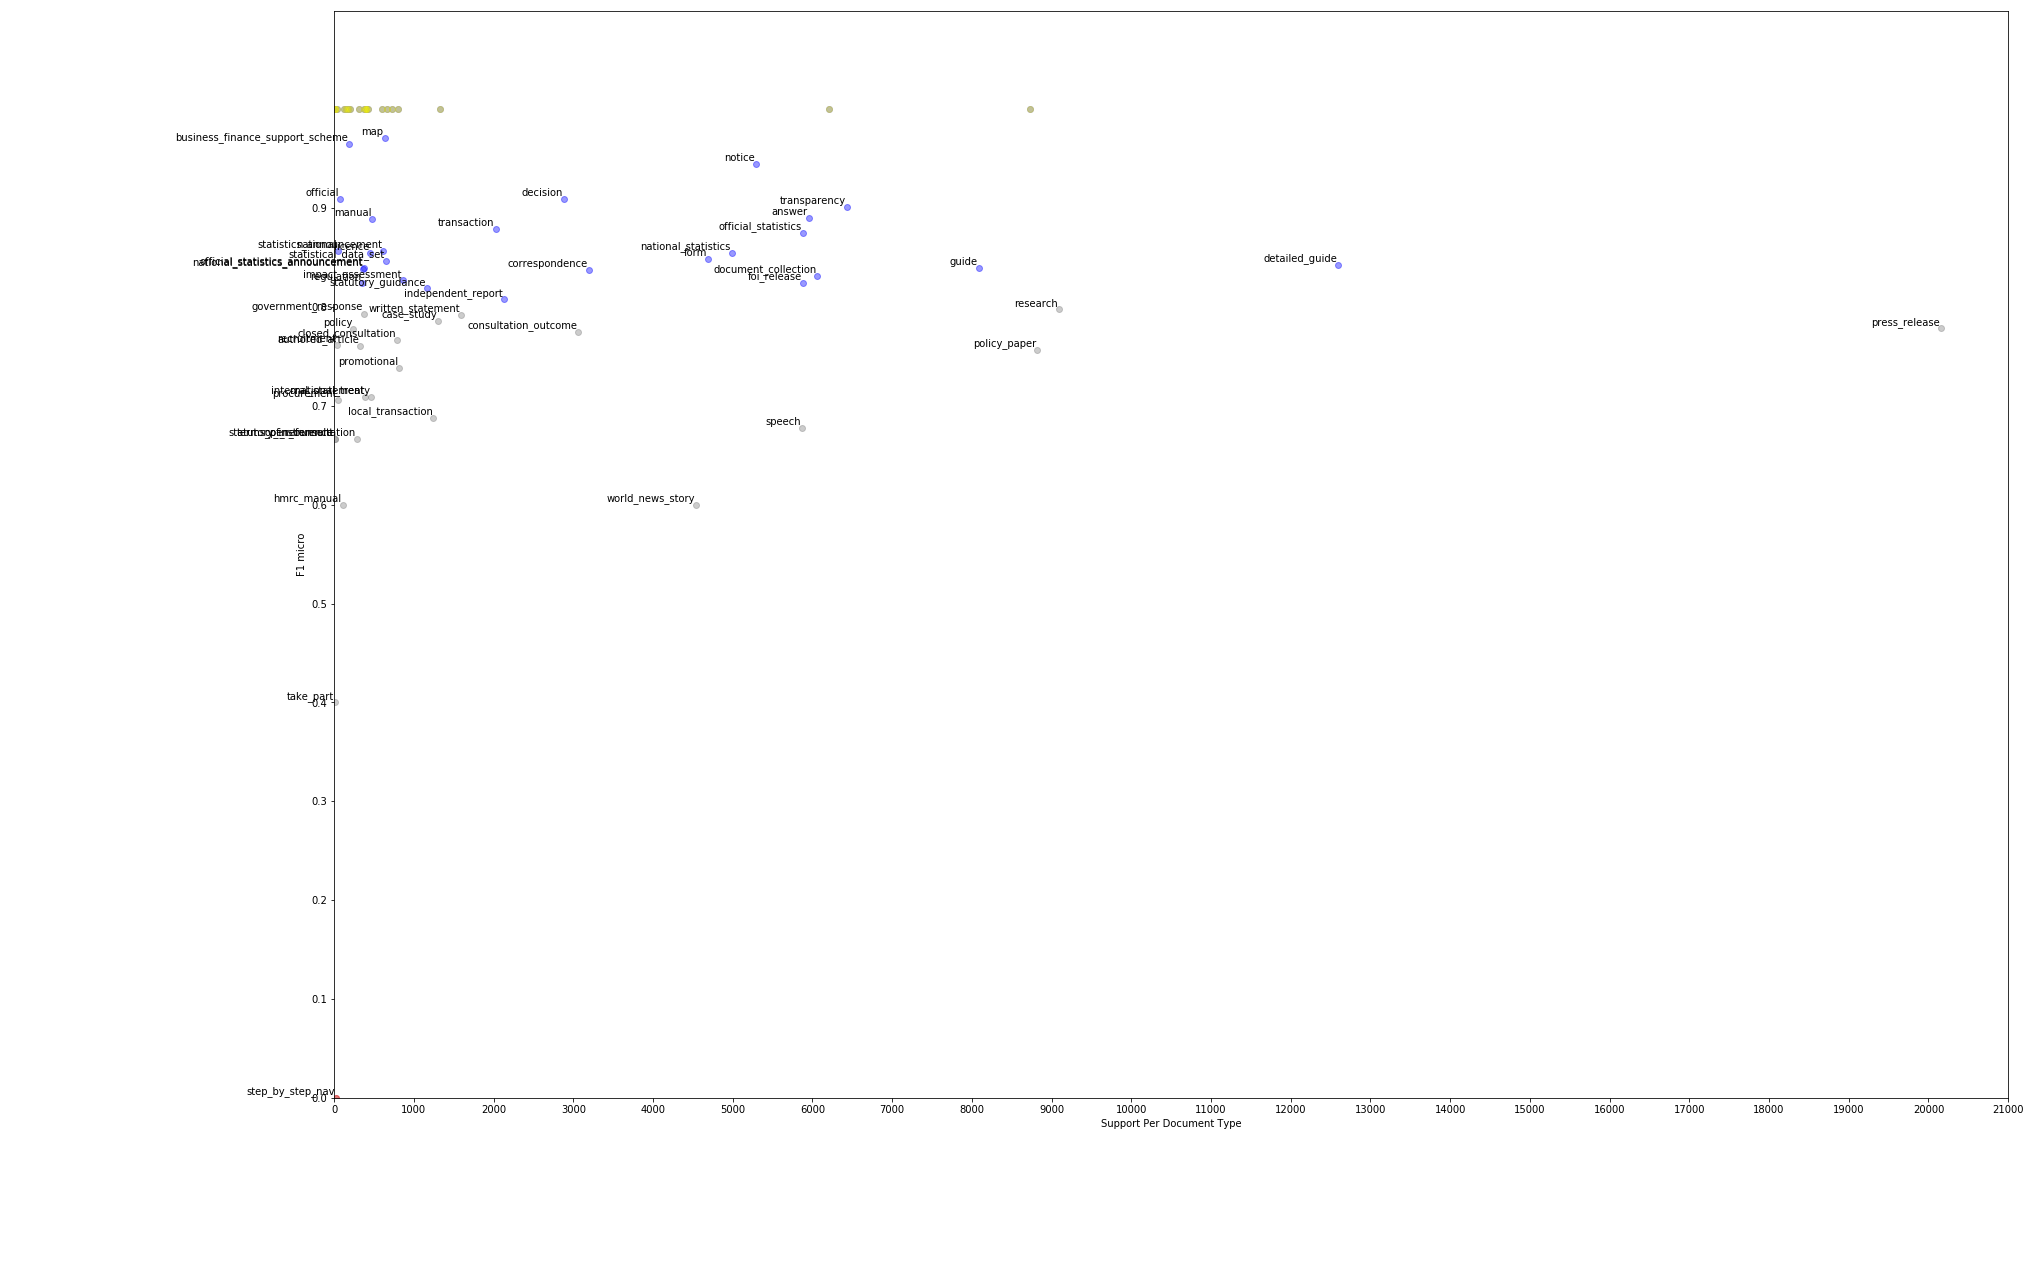

In [72]:

fig = plt.figure(figsize=(30, 20))
axes = plt.subplot()
axes.set_xlim([0,21000])
axes.set_ylim([0,1.1])

plt.xlabel('Support Per Document Type')
plt.ylabel('F1 micro')
plt.scatter(results_doc['support_doc_type'][results_doc['F1_micro']>=0.8], 
            results_doc['F1_micro'][results_doc['F1_micro']>=0.8], 
            c = 'blue', 
            alpha=.4)
# less than 0.8
plt.scatter(results_doc['support_doc_type'][results_doc['F1_micro']<0.8], 
            results_doc['F1_micro'][results_doc['F1_micro']<0.8], 
            c = 'grey', 
            alpha=.4)

plt.scatter(results_doc['support_doc_type'][results_doc['F1_micro']==0], 
            results_doc['F1_micro'][results_doc['F1_micro']==0], 
            c = 'red', 
            alpha=.4)

plt.scatter(results_doc['support_doc_type'][results_doc['F1_micro']==1], 
            results_doc['F1_micro'][results_doc['F1_micro']==1], 
            c = 'yellow', 
            alpha=.4)


for label, x, y in zip(results_doc['document_type'], results_doc['support_doc_type'], results_doc['F1_micro']):
    if y < 1:
        plt.annotate(
            label,
            xy=(x, y), xytext=(-1, 1),
            textcoords='offset points', ha='right', va='bottom')
    if (y==1):
        label = ""
        plt.annotate(
            label,
            xy=(x, y), xytext=(-1, 1),
            textcoords='offset points', ha='right', va='bottom')

plt.yticks(np.arange(0, 1, 0.1))        
plt.xticks(np.arange(0, 22000, 1000))
plt.show()

## F1 scores

## Support and performance

## Predictions

In [ ]:
predictions = pd.read_csv(os.path.join(RESULTS_DIR, 'predictions_meta.csv.gz'), dtype=object, compression='gzip')

In [ ]:
predictions.head()

In [ ]:
predictions.columns

In [ ]:
predictions = predictions[['content_id', 'prob', 'taxon2label', 'base_path', 'title', 'description',
       'combined_text', 'document_type', 'first_published_at', 'primary_publishing_organisation', 'publishing_app']]

In [ ]:
predictions[200:250].head()

In [ ]:
taxons = predictions['taxon2label'].unique()

In [ ]:
taxons

In [ ]:
subsample = pd.DataFrame(columns = predictions.columns)

In [ ]:
for taxon in taxons:
    taxon_spec = predictions.loc[predictions['taxon2label']==taxon]
    sample_size = int(round(taxon_spec.shape[0]*0.1))
    if not sample_size == 0 and taxon_spec.shape[0] > sample_size:
        print(taxon,": SAMPLING AT:",sample_size)
        subsample = subsample.append(taxon_spec.sample(n=sample_size), ignore_index=True)

In [ ]:
subsample[['taxon2label','title','combined_text','base_path']]

In [ ]:
subsample[['taxon2label','title','combined_text','base_path']].to_csv(os.path.join(RESULTS_DIR,"subsampled_predictions_10percent.csv"),index=False)